## MSE vs. NLL example

In this example, NLL (negative log likelihood) and MSE (mean-squared error) are compared: The same neural network is fitted on artificial data using the two different loss functions. The data is generated by adding Gaussian noise to a simple sinusoidal dependence.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from nn_uncertainty_estimation.losses import NegativeLogLikelihoodLoss
from nn_uncertainty_estimation.metrics import AdaptedMSEForNegativeLogLikelihoodOutput

Generate dataset:

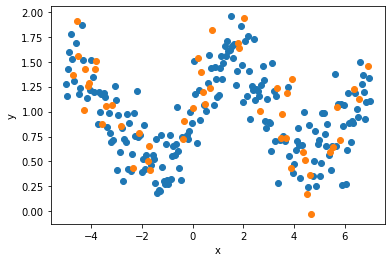

In [2]:
rng = np.random.default_rng(seed=5)

slope = 0.5
y0 = 1
noise_std = 0.25

num_samples = 250

x_min = -5.
x_max = 7.

def f(x):
    return y0 + slope * np.sin(x)

x_all = np.linspace(x_min, x_max, num_samples)
y_all_perfect = np.array([f(x) for x in x_all])

def add_constant_noise(x, noise_std):
    return rng.normal(loc=x, scale=noise_std)

y_all = np.array([add_constant_noise(y, noise_std) for y in y_all_perfect])


x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=42)
y_test_perfect = np.array([f(x) for x in x_test])

plt.scatter(x_train, y_train, label="Train")
plt.scatter(x_test, y_test, label="Test")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Build and train model using MSE loss:

Val metrics: {'loss': 0.1445198357105255, 'mean_squared_error': 0.1445198357105255}


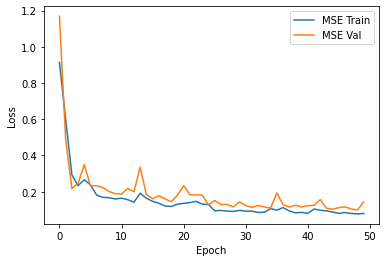

In [3]:
def build_model(num_outputs):
    inputs = tf.keras.Input(shape=(1,))
    x = inputs
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    outputs = tf.keras.layers.Dense(num_outputs, activation=None)(x)
    
    return tf.keras.models.Model(inputs=inputs, outputs=outputs)

mse_model = build_model(1)

mse_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mean_squared_error"],
)

history = mse_model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test),
                        verbose=0)

df_history = pd.DataFrame(history.history)

print("Val metrics:", mse_model.evaluate(x_test, y_test, verbose=0, return_dict=True))


plt.plot(df_history["mean_squared_error"], label="MSE Train")
plt.plot(df_history["val_mean_squared_error"], label="MSE Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Visualize predictions:

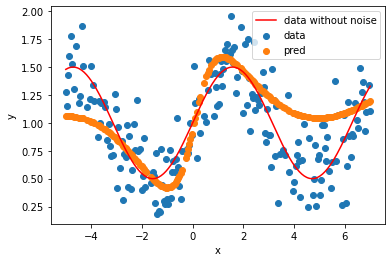

In [4]:
y_pred_train = mse_model.predict(x_train)

plt.scatter(x_train, y_train, label="data")
plt.scatter(x_train, y_pred_train, label="pred")
plt.plot(x_all, y_all_perfect, "r-", label="data without noise")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

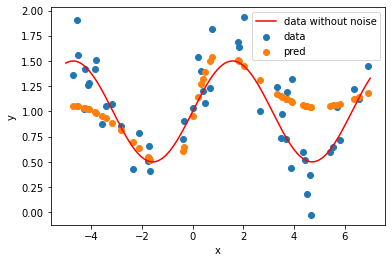

In [5]:
y_pred_test = mse_model.predict(x_test)

plt.scatter(x_test, y_test, label="data")
plt.scatter(x_test, y_pred_test, label="pred")
plt.plot(x_all, y_all_perfect, "r-", label="data without noise")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Compare predictions for model trained with MSE with noise-free ground truth:

In [6]:
mse_model.evaluate(x_test, y_test_perfect)

2/2 [==============================] - 0s 1ms/step - loss: 0.0956 - mean_squared_error: 0.0956


[0.09560984373092651, 0.09560984373092651]

Build and train model using NLL loss:

2/2 - 0s - loss: -7.0688e-01 - adapted_mse_for_nll: 0.0959
Val metrics: {'loss': -0.706881582736969, 'adapted_mse_for_nll': 0.09587281197309494}


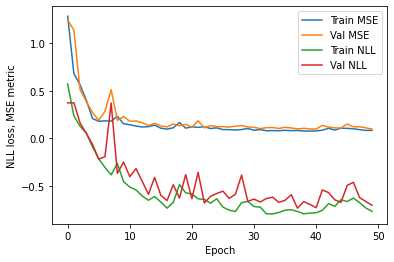

In [7]:
nll_model = build_model(2)

nll_model.compile(
    loss=NegativeLogLikelihoodLoss(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=AdaptedMSEForNegativeLogLikelihoodOutput(),
)

nll_history = nll_model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test),
                            verbose=0)

df_nll_history = pd.DataFrame(nll_history.history)

print("Val metrics:", nll_model.evaluate(x_test, y_test, verbose=2, return_dict=True))

plt.plot(df_nll_history["adapted_mse_for_nll"], label="Train MSE")
plt.plot(df_nll_history["val_adapted_mse_for_nll"], label="Val MSE")
plt.plot(df_nll_history["loss"], label="Train NLL")
plt.plot(df_nll_history["val_loss"], label="Val NLL")
plt.xlabel("Epoch")
plt.ylabel("NLL loss, MSE metric")
plt.legend()
plt.show()

Visualize predictions:

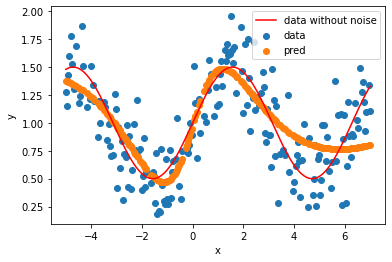

In [8]:
y_pred_train = nll_model.predict(x_train)

plt.scatter(x_train, y_train, label="data")
plt.scatter(x_train, y_pred_train[:, 0], label="pred")
plt.plot(x_all, y_all_perfect, "r-", label="data without noise")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

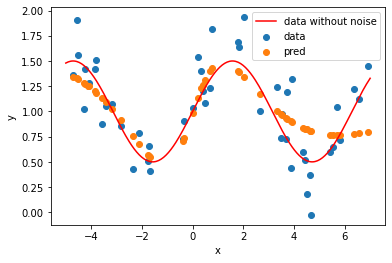

In [9]:
y_pred_test = nll_model.predict(x_test)

plt.scatter(x_test, y_test, label="data")
plt.scatter(x_test, y_pred_test[:, 0], label="pred")
plt.plot(x_all, y_all_perfect, "r-", label="data without noise")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

Compare predictions for model trained with NLL with noise-free ground truth:

In [10]:
nll_model.evaluate(x_test, y_test_perfect)

2/2 [==============================] - 0s 2ms/step - loss: -1.1019 - adapted_mse_for_nll: 0.0308


[-1.101929783821106, 0.030766749754548073]

Predicted standard deviation as a function of `x`:

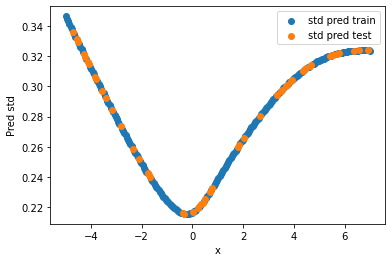

In [11]:
plt.scatter(x_train, np.exp(0.5 * y_pred_train[:, 1]), label="std pred train")
plt.scatter(x_test, np.exp(0.5 * y_pred_test[:, 1]), label="std pred test")
plt.legend()
plt.xlabel("x")
plt.ylabel("Pred std")
plt.show()

Plot predicted standard deviation and actual error for a wider range of `x` values:

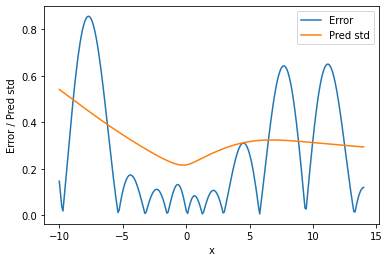

In [12]:
x_all_extended = np.linspace(2*x_min, 2*x_max, num_samples)
y_gt_extended = np.array([f(x) for x in x_all_extended])

y_pred_extended = nll_model.predict(x_all_extended)

plt.plot(x_all_extended, np.abs(y_gt_extended - y_pred_extended[:, 0]), label="Error")
plt.plot(x_all_extended, np.exp(0.5 * y_pred_extended[:, 1]), label="Pred std")
plt.xlabel("x")
plt.ylabel("Error / Pred std")
plt.legend()
plt.show()

The model trained with NLL loss yields a slightly lower mean-squared error on the test dataset than the model trained using MSE loss. This is a consequence of the fact that the NLL loss suppresses the contribution of points with larger uncertainty in the data, for example from nearby `x` values whose `y` values differ greatly due to noise. The predicted standard deviation on the test set compares well with the actual value that was chosen when generating the data. 

Training a regression model with NLL loss allows to estimate the data uncertainty (aleatoric uncertainty), as shown above, but not the model uncertainty (epistemic uncertainty). This can be seen in the last diagram, from which it is not straightforward to decide where the support of the model ends and samples are outside of the training distribution. For estimating model uncertainty, one would need to use other methods like Monte Carlo Dropout or ensemble methods. 